<a href="https://colab.research.google.com/github/Priesemann-Group/covid19_inference_forecast/blob/master/scripts/example_script_covid19_inference_complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks run an SEIR-like model. Details can be found in the documentation: https://covid19-inference-forecast.readthedocs.io/en/latest/doc/models.html

##Installation
Run this if the module isn't installed yet or is run in Google Colab

In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference_forecast.git

#Fit Model

In [2]:
import sys
sys.path.append('..')
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

if 1:
    sys.path.append('..')
    import covid19_inference as cov19

confirmed_cases = cov19.get_rki_EpiCurve("dayily_obs")

country = 'Germany'
date_data_begin = datetime.datetime(2020,2,25)
date_data_end   = datetime.datetime(2020,4,4)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 14
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = confirmed_cases["Total"]

print(len(cases_obs),"\n",cases_obs)

change_points = [dict(pr_mean_date_begin_transient = datetime.datetime(2020,3,9),
                      pr_median_lambda = 1)]#,
unused_points = [                 dict(pr_mean_date_begin_transient = datetime.datetime(2020,3,16),
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.5,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = datetime.datetime(2020,3,23),
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.1,
                      pr_sigma_lambda = 0.3)]


Data not available online, using local copy.
40 
 0        85
1       211
2       345
3       516
4       670
5       832
6      1080
7      1312
8      1642
9      1983
10     2514
11     3213
12     4132
13     5522
14     7296
15     9533
16    11956
17    14965
18    18026
19    21138
20    25256
21    28752
22    32307
23    35383
24    38927
25    41805
26    44158
27    47527
28    50053
29    52773
30    55180
31    57599
32    59891
33    61696
34    64171
35    66004
36    68043
37    69884
38    71666
39    72949
Name: Total, dtype: int64


#Plotting

In [3]:
model = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                   N=83e6,
                                   priors_dict=dict(pr_sigma_random_walk=0.1),
                                   with_random_walk=True)

trace = pm.sample(model=model, init='advi', draws=10)
# advi is important as initialization, other initializations methods lead
# to more divergences

pr_beta_I_begin was set to default value 100
pr_beta_E_begin_scale was set to default value 10
pr_median_lambda_0 was set to default value 2
pr_sigma_lambda_0 was set to default value 0.7
pr_median_mu was set to default value 0.3333333333333333
pr_sigma_mu was set to default value 0.3
pr_median_delay was set to default value 5
pr_sigma_delay was set to default value 0.2
scale_delay was set to default value 0.3
pr_beta_sigma_obs was set to default value 10
pr_mean_median_incubation was set to default value 5
pr_sigma_median_incubation was set to default value 1
sigma_incubation was set to default value 0.418
pr_sigma_lambda of change point 0 was set to default value 0.7
pr_sigma_date_begin_transient of change point 0 was set to default value 3
pr_median_transient_len of change point 0 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 374.69:   8%|▊         | 15699/200000 [01:24<16:36, 185.00it/s]
Convergence achieved at 15700
Interrupted at 15,699 [7%]: Average Loss = 1,398.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [median_incubation, sigma_obs, delay, mu, lambda_t_random_walk, sigma_random_walk, transient_len_0, transient_begin_0, lambda_1, lambda_0, E_begin, E_begin_scale, I_begin]
Sampling 4 chains, 0 divergences: 100%|██████████| 2040/2040 [13:26<00:00,  2.53draws/s]
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


Text(0, 0.5, 'lambda_t_random_walk with 75% CI')

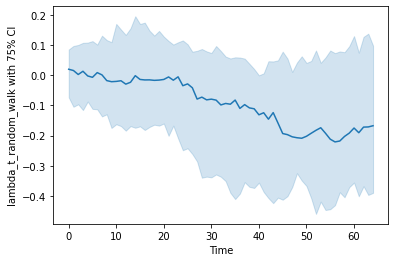

In [4]:
time_arr = np.arange(trace.lambda_t_random_walk.shape[1])
plt.plot(time_arr, np.median(trace.lambda_t_random_walk, axis=0))
plt.fill_between(time_arr, *np.percentile(trace.lambda_t_random_walk, axis=0, q=(12.5,87.5)), color='tab:blue', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('lambda_t_random_walk with 75% CI')

Dimension of E_begin larger than one, skipping
Dimension of lambda_t_random_walk larger than one, skipping


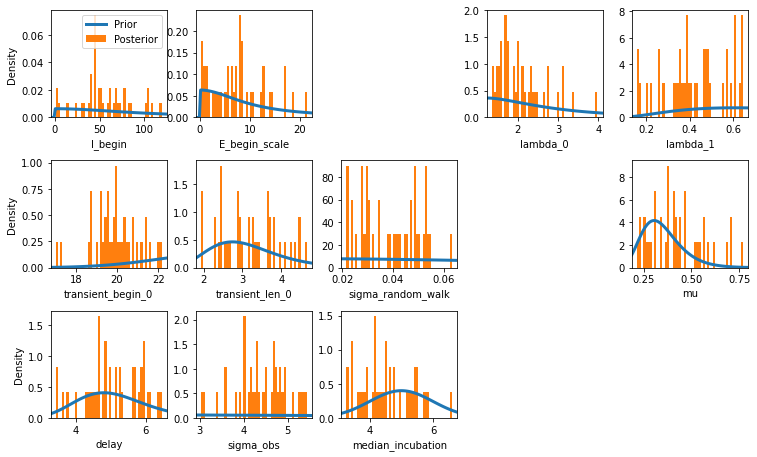

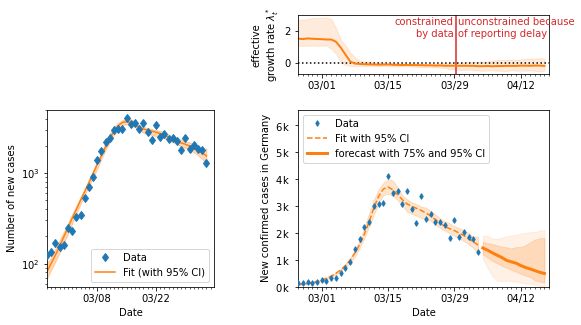

In [5]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax])
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, np.diff(cases_obs), date_begin_sim, diff_data_sim)